In [146]:
import pandas as pd
import csv
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [147]:
buy_behavior = pd.read_csv('buy_behavior_log.csv')
number_of_queries = buy_behavior.shape[0]
unique_brands = buy_behavior["brand"].unique()
unique_users = buy_behavior["user"].unique()

print(len(unique_brands))
print(len(unique_users))
print(number_of_queries)

buy_behavior.head(5)

206307
997816
9115919


,user,time_stamp,btag,cate,brand
0,916958,1493811673,buy,123,97176
1,916958,1493811809,buy,123,97176
2,628854,1493781424,buy,4262,370203
3,623496,1493810730,buy,4262,370203
4,1099015,1493774927,buy,9390,347564


In [148]:
user_profile = pd.read_csv('user_profile.csv')

user_profile.head(5)

,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,234,0,5,2,5,NaN,3,0,3.0
1,523,5,2,2,2,1.0,3,1,2.0
2,612,0,8,1,2,2.0,3,0,NaN
3,1670,0,4,2,4,NaN,1,0,NaN
4,2545,0,10,1,4,NaN,3,0,NaN


In [149]:
# Merge the top_5_buy_behavior and user_profile dataframes on the 'userid' column
merged_df = pd.merge(buy_behavior, user_profile, left_on='user', right_on='userid')
print(merged_df)

           user  time_stamp btag  cate   brand  userid  cms_segid  \
0        916958  1493811673  buy   123   97176  916958         33   
1        916958  1493811809  buy   123   97176  916958         33   
2        916958  1494055722  buy  4267  178847  916958         33   
3        916958  1494037918  buy   123   97176  916958         33   
4        916958  1493811673  buy   123   97176  916958         33   
...         ...         ...  ...   ...     ...     ...        ...   
8825410  319183  1493526092  buy  2505  412044  319183         92   
8825411  889393  1493567745  buy  6181  264201  889393         60   
8825412  401828  1493532067  buy  1892  398556  401828          0   
8825413  614980  1493525415  buy  8998  224985  614980          0   
8825414  614980  1493525641  buy  8998  224985  614980          0   

         cms_group_id  final_gender_code  age_level  pvalue_level  \
0                   4                  2          4           2.0   
1                   4            

In [150]:
def analysis(data, sensitive_attribute_val, analysis_val):
    
    attribute_mapping = {1: 'final_gender_code', 2: 'age_level', 3: 'pvalue_level', 4: 'occupation'}
    sensitive_attribute = attribute_mapping[sensitive_attribute_val]
    
    brand_mapping = {1: 'brand', 2: 'brand_combined'}
    analysis_str = brand_mapping[analysis_val]
    
    # Group the merged dataframe by the 'brand' and 'pvalue_level' columns and get the count of each group
    grouped_df = data.groupby([analysis_str, sensitive_attribute], as_index=False).count()[[analysis_str, sensitive_attribute, 'user']]

    # Pivot the grouped dataframe to create a pivot table with the 'brand' column as the index, the 'pvalue_level' column as the columns and the 'user' column as the values
    pivot_table = grouped_df.pivot(index=analysis_str, columns=sensitive_attribute, values='user')
    pivot_table = pivot_table.fillna(0)
    
    # Get the total number of users for each gender
    brand_totals = pivot_table.sum(axis=1)

    # Divide the values in the pivot table by the gender totals and multiply by 100 to get the percent values
    percent_table = (pivot_table / brand_totals.values.reshape(-1, 1)) * 100
    percent_table = percent_table.fillna(0)
    percent_table = percent_table.round(2)

    # Find ambiguity value by subtracting max frequency from 100 in each row
    ambiguity_values = 100 - percent_table.max(axis=1)

    # Create new dataframe with brand and ambiguity value
    ambiguity_table = pd.DataFrame({analysis_str: percent_table.index, 'ambiguity': ambiguity_values.round(2)}).reset_index(drop=True)

    # Display the new dataframe

    amb_dict = dict(ambiguity_table['ambiguity'].value_counts())

    # Sort the dictionary items by their keys
    ambiguity_dict_attribute = dict(sorted(amb_dict.items(), key=lambda x: x[0]))

    ambiguity_users = {}

    for index, row in ambiguity_table.iterrows():
        brand = row[analysis_str]
        ambiguity_value = row['ambiguity']
        pivot_row = pivot_table.loc[brand]
        total_users = int(pivot_row.sum())

        if ambiguity_value in ambiguity_users:
            ambiguity_users[ambiguity_value] += total_users

        else:
            ambiguity_users[ambiguity_value] = total_users

    ambiguity_users = dict(sorted(ambiguity_users.items(), key=lambda x: x[0]))
    
    return pivot_table, ambiguity_dict_attribute, ambiguity_users


    

In [151]:
####### Performing all the single brands Analysis ########

In [152]:
####### Gender Analysis ########
# gender 1 for male , 2 for female

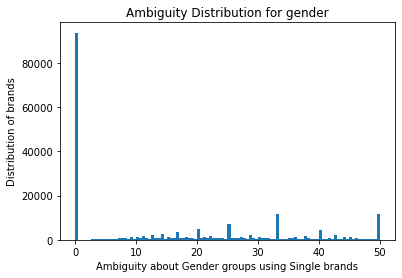

In [153]:
pivot_table_gender, ambiguity_dict_gender, ambiguity_users_gender = analysis(merged_df, 1, 1)
x_values = list(ambiguity_dict_gender.keys())
y_values = list(ambiguity_dict_gender.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Gender groups using Single brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for gender')

# Show the plot
plt.show()

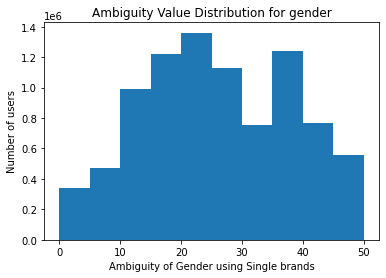

In [154]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_gender.keys())
y_values = list(ambiguity_users_gender.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for gender')
plt.show()

In [155]:
######## Age Analysis #########
# 7 age groups

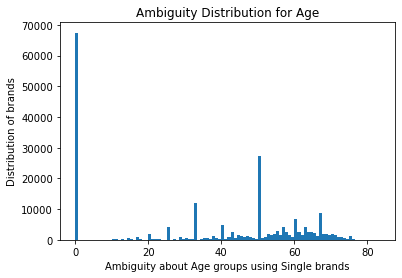

In [156]:
pivot_table_age, ambiguity_dict_age, ambiguity_users_age = analysis(merged_df, 2, 1)
x_values = list(ambiguity_dict_age.keys())
y_values = list(ambiguity_dict_age.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Age groups using Single brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Age')

# Show the plot
plt.show()

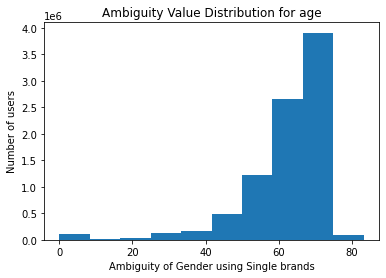

In [157]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_age.keys())
y_values = list(ambiguity_users_age.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for age')
plt.show()

In [158]:
###### pvalue_level ######

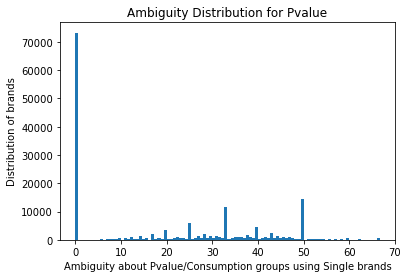

In [159]:
pivot_table_pval, ambiguity_dict_pval, ambiguity_users_pval = analysis(merged_df, 3, 1)
x_values = list(ambiguity_dict_pval.keys())
y_values = list(ambiguity_dict_pval.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Pvalue/Consumption groups using Single brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Pvalue')

# Show the plot
plt.show()

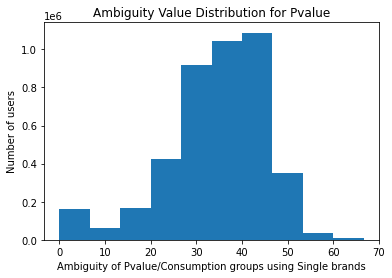

In [160]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_pval.keys())
y_values = list(ambiguity_users_pval.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Pvalue/Consumption groups using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Pvalue')
plt.show()

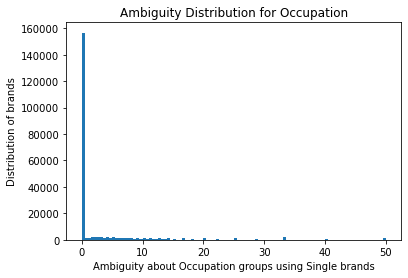

In [161]:
###### occupation ######
# Is the college student 1: yes, 0: no?

pivot_table_occup, ambiguity_dict_occup, ambiguity_users_occup = analysis(merged_df, 4, 1)
x_values = list(ambiguity_dict_occup.keys())
y_values = list(ambiguity_dict_occup.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Occupation groups using Single brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Occupation')

# Show the plot
plt.show()

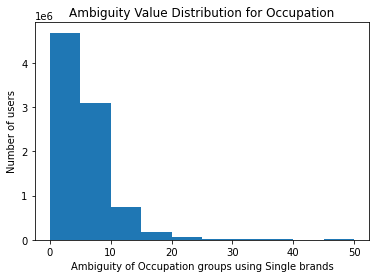

In [162]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_occup.keys())
y_values = list(ambiguity_users_occup.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Occupation groups using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Occupation')
plt.show()

In [163]:
######### Intersection Sensitive Attribute Attack ##########

In [164]:
"""
buy_behavior_combined = pd.read_csv('taobao_dataset_with_orders_400K_2.csv')
number_of_queries = buy_behavior_combined.shape[0]
unique_brands = buy_behavior_combined["brand"].unique()
unique_users = buy_behavior_combined["user"].unique()

print(len(unique_brands))
print(len(unique_users))
print(number_of_queries)

buy_behavior.head(5)
"""



'\nbuy_behavior_combined = pd.read_csv(\'taobao_dataset_with_orders_400K_2.csv\')\nnumber_of_queries = buy_behavior_combined.shape[0]\nunique_brands = buy_behavior_combined["brand"].unique()\nunique_users = buy_behavior_combined["user"].unique()\n\nprint(len(unique_brands))\nprint(len(unique_users))\nprint(number_of_queries)\n\nbuy_behavior.head(5)\n'

In [165]:
"""
brand_combinations = [(93068, 11299),(93403, 12869),(124290, 18593),(392793, 18593),(18595, 143597),(92746, 132243),(92746, 257414),(95766, 168008),(95766, 370203),(124290, 132243),
(124290, 392793),(129994, 132243),(129994, 286752),(340073, 129994),(199354, 132243),(257414, 132243),(286752, 132243),(313898, 132243),(146115, 143597),(247789, 143597),(143597, 370203),(146115, 370203),
(442842, 156936),(168008, 370203),(199354, 406146),(224985, 370203),(353787, 236707),(247789, 252916),(247789, 370203),(248775, 286752),(370203, 293023),
(342760, 370203),(370203, 366684),(370203, 388700),(390518, 370203),(370203, 425589),(437724, 370203),(437724, 388700)]

merged_data = pd.merge(buy_behavior_combined, user_profile, left_on='user', right_on='userid')
# Drop the 'userid' column since it contains the same values as 'user'
merged_data = merged_data.drop('userid', axis=1)
merged_data.head(5)

"""


"\nbrand_combinations = [(93068, 11299),(93403, 12869),(124290, 18593),(392793, 18593),(18595, 143597),(92746, 132243),(92746, 257414),(95766, 168008),(95766, 370203),(124290, 132243),\n(124290, 392793),(129994, 132243),(129994, 286752),(340073, 129994),(199354, 132243),(257414, 132243),(286752, 132243),(313898, 132243),(146115, 143597),(247789, 143597),(143597, 370203),(146115, 370203),\n(442842, 156936),(168008, 370203),(199354, 406146),(224985, 370203),(353787, 236707),(247789, 252916),(247789, 370203),(248775, 286752),(370203, 293023),\n(342760, 370203),(370203, 366684),(370203, 388700),(390518, 370203),(370203, 425589),(437724, 370203),(437724, 388700)]\n\nmerged_data = pd.merge(buy_behavior_combined, user_profile, left_on='user', right_on='userid')\n# Drop the 'userid' column since it contains the same values as 'user'\nmerged_data = merged_data.drop('userid', axis=1)\nmerged_data.head(5)\n\n"

In [168]:
top_brands = buy_behavior['brand'].value_counts().head(100).index.tolist()
top_brands_data = buy_behavior[buy_behavior['brand'].isin(top_brands)]

merged_data = pd.merge(top_brands_data, user_profile, left_on='user', right_on='userid')
# Drop the 'userid' column since it contains the same values as 'user'
merged_data = merged_data.drop('userid', axis=1)
merged_data.head(5)

brand_combinations = list(itertools.combinations(top_brands, 2))
print(brand_combinations)

[(370203, 388700), (370203, 247789), (370203, 224985), (370203, 425589), (370203, 168008), (370203, 124290), (370203, 95766), (370203, 273201), (370203, 98931), (370203, 392793), (370203, 18593), (370203, 353787), (370203, 143597), (370203, 38543), (370203, 146115), (370203, 303910), (370203, 293023), (370203, 342760), (370203, 336520), (370203, 184921), (370203, 390518), (370203, 235358), (370203, 252916), (370203, 36241), (370203, 188059), (370203, 156936), (370203, 234846), (370203, 160582), (370203, 303785), (370203, 207245), (370203, 236225), (370203, 129994), (370203, 222087), (370203, 95618), (370203, 201713), (370203, 437724), (370203, 132353), (370203, 12869), (370203, 88078), (370203, 195240), (370203, 39211), (370203, 82527), (370203, 282953), (370203, 188080), (370203, 339907), (370203, 342533), (370203, 400399), (370203, 335394), (370203, 93403), (370203, 83456), (370203, 101384), (370203, 90282), (370203, 423617), (370203, 269810), (370203, 78538), (370203, 22641), (37020

In [167]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


result_df = pd.DataFrame(columns=['age_level', 'final_gender_code', 'pvalue_level', 'occupation'])

for brand_combo in brand_combinations:
    brand1, brand2 = brand_combo
    brand_data = merged_data[(merged_data['brand']==brand1) & (merged_data['user'].isin(merged_data[merged_data['brand']==brand2]['user'].tolist()))]
    brand_data['brand2'] = brand2
    user_data = brand_data[['user','brand', 'brand2', 'age_level', 'final_gender_code', 'pvalue_level', 'occupation']]
    result_df = result_df.append(user_data, ignore_index=True)
result_df = result_df.drop_duplicates(keep='first')

# Combine the brand and brand2 columns into a single column called "brand_combined"
result_df['brand_combined'] = result_df['brand'].fillna(0).astype(int).astype(str) + '_' + result_df['brand2'].fillna(0).astype(int).astype(str)

# Drop the original brand and brand2 columns
result_df.drop(['brand', 'brand2'], axis=1, inplace=True)
print(result_df)

KeyboardInterrupt: 

In [ ]:
####### Gender analysis Combined brands #######

In [ ]:
pivot_table_gender, ambiguity_dict_gender, ambiguity_users_gender = analysis(result_df, 1, 2)
x_values = list(ambiguity_dict_gender.keys())
y_values = list(ambiguity_dict_gender.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Gender groups using Combination of brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for gender')

# Show the plot
plt.show()

In [ ]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_gender.keys())
y_values = list(ambiguity_users_gender.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Combination of brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for gender')
plt.show()

In [ ]:
######## Age Analysis #########
# 7 age groups

In [ ]:
pivot_table_age, ambiguity_dict_age, ambiguity_users_age = analysis(result_df, 2, 2)
x_values = list(ambiguity_dict_age.keys())
y_values = list(ambiguity_dict_age.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Age groups using Combination of brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Age')

# Show the plot
plt.show()

In [ ]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_age.keys())
y_values = list(ambiguity_users_age.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Combination brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Age')
plt.show()

In [ ]:
###### pvalue_level ######
# 1: low 2: medium 3: high consumption levels

In [ ]:
pivot_table_pval, ambiguity_dict_pval, ambiguity_users_pval = analysis(merged_df, 3, 2)
x_values = list(ambiguity_dict_pval.keys())
y_values = list(ambiguity_dict_pval.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Pvalue/Consumption groups using Combination of brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Pvalue')

# Show the plot
plt.show()

In [ ]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_pval.keys())
y_values = list(ambiguity_users_pval.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Pvalue/Consumption groups using Comniation of brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Pvalue')
plt.show()

In [ ]:
######## Occupation #######
# 1: college student 0: not a colllege student

In [ ]:
###### occupation ######
# Is the college student 1: yes, 0: no?

pivot_table_occup, ambiguity_dict_occup, ambiguity_users_occup = analysis(merged_df, 4, 2)
x_values = list(ambiguity_dict_occup.keys())
y_values = list(ambiguity_dict_occup.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Occupation groups using Combination of brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Occupation')

# Show the plot
plt.show()

In [ ]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_occup.keys())
y_values = list(ambiguity_users_occup.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Occupation groups using Combination of brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Occupation')
plt.show()